In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data.data_ashare import AShareData,AShareDataModule
from model.base import ExperimentFactory
import subprocess
import os 
from scipy.ndimage import gaussian_filter1d
from json import load
from model import CNN2, LSTM, Transformer_AE, iTransformer, TimesNet, TimeMixer, DeepLOB, TransLOB, SimLOB

In [2]:

def load_data(dataset_path="dataset/real_data/raw_data/sz000001-level10.csv",index=0):
    ashare_data = AShareData(dataset_path=dataset_path, dataset_name="unbalanced")
    ashare_data_module = AShareDataModule(datasets=ashare_data,batch_size=128)
    return ashare_data_module.train_dataloader().dataset

def reconstructed_data(model_config_path, model_path, data):
    ef = ExperimentFactory(model_config_path, model_path=model_path)
    ef.create_model()
    model = ef.model

    result = model.reconstruction(data)
    return result 

d_dataset = load_data()
print(d_dataset[0])


(tensor([[-0.8384, -0.8340, -0.8301,  ..., -0.2981, -0.4141, -0.4980],
        [-0.8340, -0.8301, -0.8257,  ..., -0.4141, -0.4980, -0.3579],
        [-0.8340, -0.8301, -0.8257,  ..., -0.4141, -0.4951, -0.3579],
        ...,
        [-0.8301, -0.8257, -0.8218,  ..., -0.4646, -0.3740, -0.5552],
        [-0.8340, -0.8301, -0.8257,  ..., -0.4021, -0.4646, -0.3740],
        [-0.8301, -0.8257, -0.8218,  ..., -0.4646, -0.3740, -0.5552]]), tensor(1.))


In [22]:
def model_loader(model_name,task_name = "reconstruction",ckpt_path="",d_model=128,unified_d=256,dropout=0.1,seq_len=100,decoder_name="transformer_decoder"):
    if model_name == "cnn2":
        model_config= {
            "task_name": task_name,
            "d_model": d_model,
            "num_class": 3,
            "unified_d": unified_d,
            "dropout": dropout,
            "checkpoint_path": ckpt_path,
            "decoder_name":decoder_name,
            "seq_len": seq_len,
            "enc_in":40
        }
        model = CNN2.load_from_checkpoint(**model_config)


    elif model_name == "lstm":
        model_config = {
            "task_name": task_name,
            "d_model": d_model,
            "unified_d": unified_d,
            "dropout": dropout,
            "enc_in": 40,
            "seq_len": seq_len,
            "decoder_name":decoder_name,
            "checkpoint_path": ckpt_path
        }
        model = LSTM.load_from_checkpoint(**model_config)

    
    elif model_name == "transformer":
        model_config = {
            "task_name": task_name,
            "d_model": d_model,
            "unified_d": unified_d,
            "dropout": dropout,
            "enc_in": 40,
            "nhead": 8,
            "num_encoder_layers": 6,
            "num_decoder_layers": 6,
            "dim_feedforward": 2048,
            "seq_len": seq_len,
            "decoder_name":decoder_name,
            "checkpoint_path": ckpt_path
            }
        model = Transformer_AE.load_from_checkpoint(**model_config)

    elif model_name == "itransformer":
        model_config = {
            "task_name": task_name,
            "d_model": d_model,
            "unified_d": unified_d,
            "dropout": dropout,
            "enc_in": 40,
            "seq_len": seq_len,
            "decoder_name":decoder_name,
            "checkpoint_path": ckpt_path,
            #####
            "e_layers": 3,
            "d_ff": 256,
            "freq": "s",
            "output_attention": False,
            "embed": "timeF",
            "factor": 1,
            "n_heads": 8,
            "activation": "gelu",
        }
        model = iTransformer.load_from_checkpoint(**model_config)
    elif model_name == "timesnet":
        model_config = {
            "task_name": task_name,
            "unified_d": unified_d,
            "dropout": dropout,
            "enc_in": 40,
            "seq_len": seq_len,
            "decoder_name":decoder_name,
            "checkpoint_path": ckpt_path,
            #####
            "pred_len": 0,
            "e_layers": 3,
            "d_model": 32,
            "d_ff": 64,
            "embed": "timeF",
            "freq": "s",
            "num_kernels": 6,
            "top_k": 3,
        }
        model = TimesNet.load_from_checkpoint(**model_config)
    elif model_name == "timemixer":
        model_config = {
            "task_name": task_name,
            "unified_d": unified_d,
            "dropout": dropout,
            "enc_in": 40,
            "seq_len": seq_len,
            "decoder_name":decoder_name,
            "checkpoint_path": ckpt_path,
            #########
            "pred_len": 0,
            "e_layers": 2,
            "d_model": 16,
            "d_ff": 32,
            "down_sampling_window": 2,
            "down_sampling_layers": 3,
            "down_sampling_method": "avg",
            "channel_independence": 0,
            "moving_avg": 25,
            "decomp_method": "moving_avg",
            "use_norm": 1,
            "c_out": 40,
            "embed": "timeF",
            "freq": "s",
            "num_kernels": 6,
            "top_k": 3
        }
        model = TimeMixer.load_from_checkpoint(**model_config)
    elif model_name == "deeplob":   
        model_config = {
            "task_name": task_name,
            "d_model": 256,
            "unified_d": unified_d,
            "enc_in": 40,
            "seq_len": seq_len,
            "decoder_name":decoder_name,
            "checkpoint_path": ckpt_path
        }
        model = DeepLOB.load_from_checkpoint(**model_config)
    elif model_name == "translob":
        model_config = {
            "task_name": task_name,
            "d_model": 256,
            "unified_d": unified_d,
            "enc_in": 40,
            "seq_len": seq_len,
            "decoder_name":decoder_name,
            "checkpoint_path": ckpt_path
        }
        model = TransLOB.load_from_checkpoint(**model_config)
    elif model_name == "simlob":
        model_config = {
                "task_name": task_name,
                "d_model": d_model,
                "unified_d": unified_d,
                "dropout": dropout,
                "trans_embed_size": 256,
                "multi_head_num": 2,
                "trans_encoder_layer": 6,
                "feed_forward": True,
                "checkpoint_path": ckpt_path,
                "decoder_name":decoder_name,
                "seq_len": seq_len,
                "enc_in":40
        }
        model = SimLOB.load_from_checkpoint(**model_config)
    else:
        print("Model not found")
        return None
        
    
    return model 


models_name = [
    "cnn2","lstm","transformer","timemixer","itransformer","timesnet","deeplob","translob","simlob"
]


reconstruction_paths_template = "report/results/experiments/models/[A5000]reconstruction_{}_all_ashare_sz000001:v1.0.0.ckpt"

m_test = 'deeplob'
model = model_loader(m_test,ckpt_path=reconstruction_paths_template.format(m_test))



In [60]:

print(d[0].unsqueeze(0))

tensor([[[0.2588, 0.2629, 0.2671,  ..., 0.1807, 0.2023, 1.0547],
         [0.2588, 0.2629, 0.2671,  ..., 0.1833, 0.2023, 1.0547],
         [0.2588, 0.2629, 0.2671,  ..., 0.1794, 0.2023, 1.0547],
         ...,
         [0.2754, 0.2795, 0.2837,  ..., 4.9648, 0.3516, 1.9229],
         [0.2754, 0.2795, 0.2837,  ..., 0.3516, 1.9229, 0.2803],
         [0.2795, 0.2837, 0.2878,  ..., 0.3516, 1.9229, 0.2803]]])


In [57]:
result = model(d[0].unsqueeze(0),None)

In [59]:
print(result)

tensor([[[ 0.0430,  0.0631, -0.0013,  ..., -0.0306, -0.0433, -0.1522],
         [-0.0671,  0.0353, -0.0098,  ...,  0.0353,  0.0077, -0.1498],
         [-0.0664,  0.0571,  0.0046,  ..., -0.0016, -0.0385, -0.0052],
         ...,
         [-0.0678, -0.0339, -0.0306,  ..., -0.0395,  0.0613,  0.1501],
         [-0.1023,  0.1179,  0.0367,  ...,  0.1010, -0.0095,  0.0858],
         [ 0.0343, -0.0013, -0.0092,  ...,  0.0647,  0.0660, -0.0176]]],
       grad_fn=<ViewBackward0>)


/var/folders/hs/p_t7843d0wdc8q0z06yq2xh80000gn/T/ipykernel_5824/1596378443.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='best')


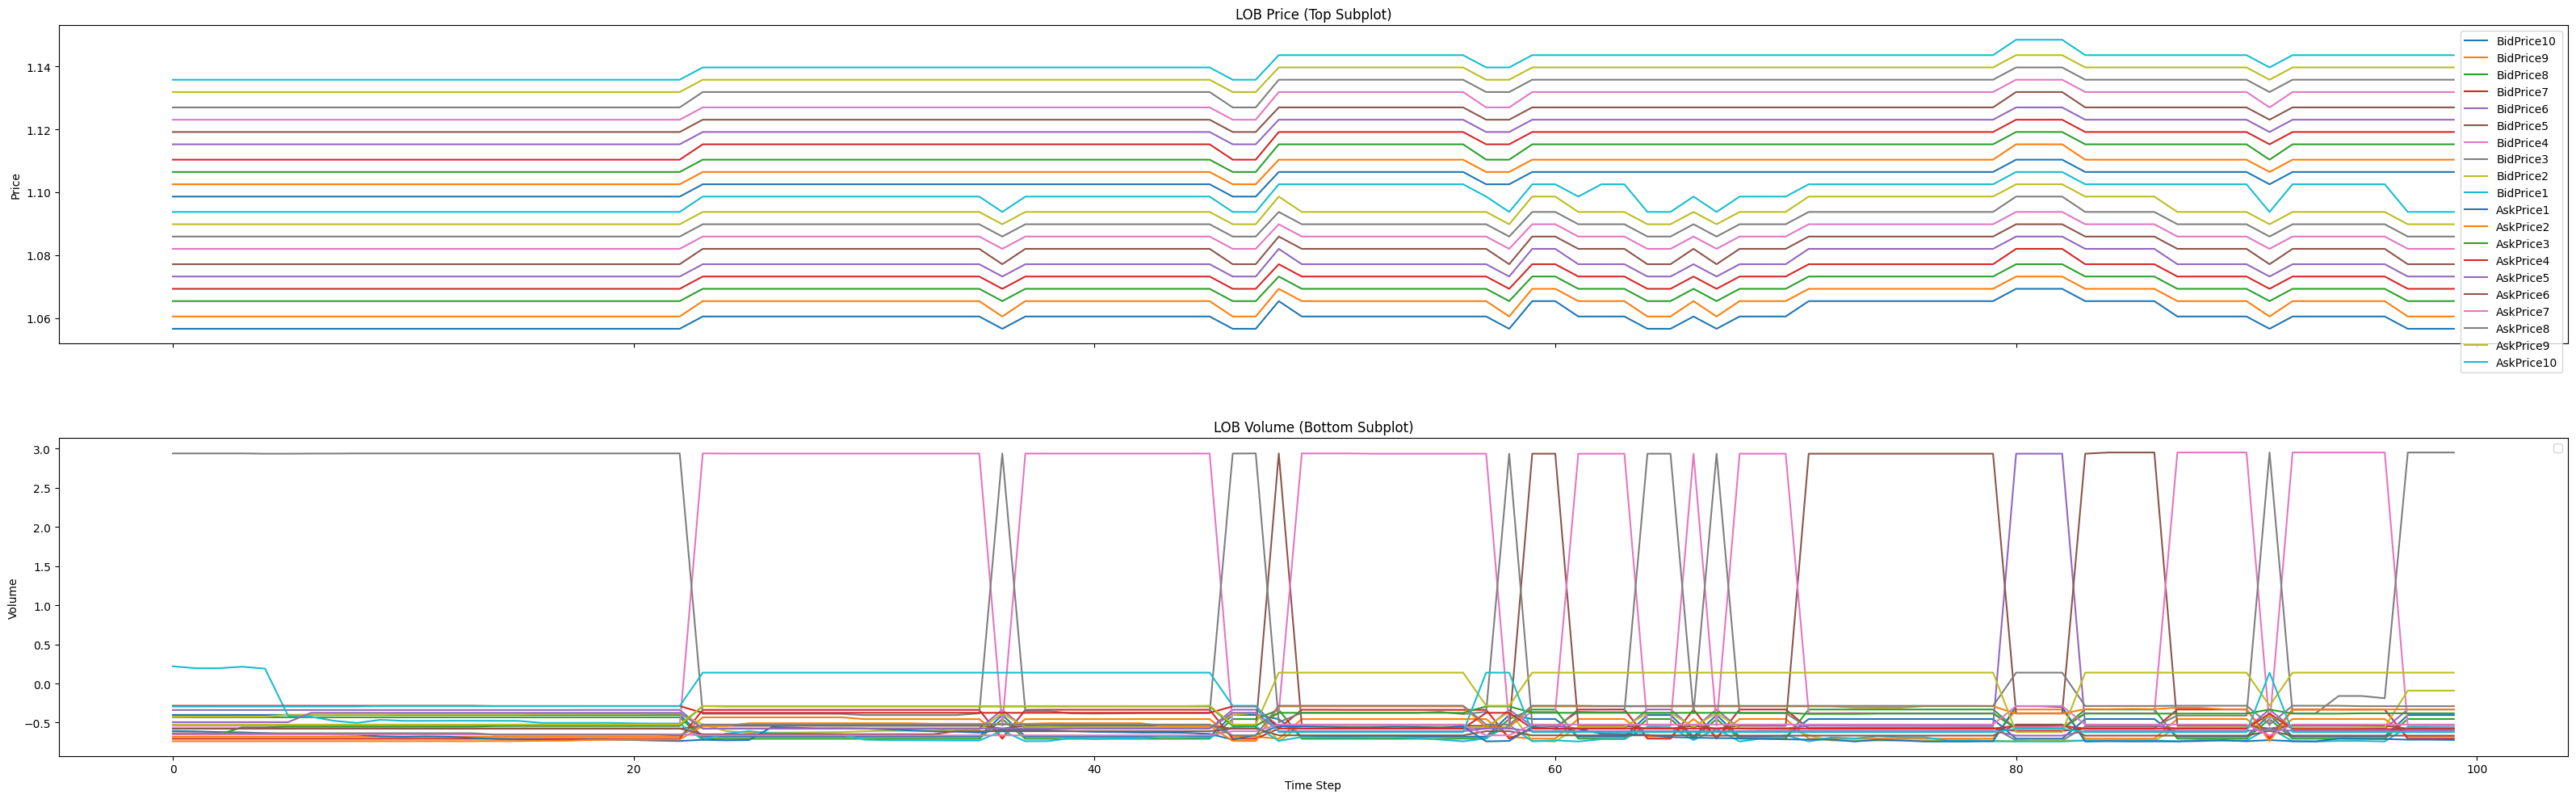

In [ ]:
from cProfile import label


def plot_lob(data, price=True, volume=True, show=True):
    """
    绘制 LOB 数据的示例方法。
    
    参数:
    -------
    data: np.ndarray
        输入形状为 (40, 100) 的二维数据，其中:
          - data[:20, :] 为价格序列
          - data[20:, :] 为成交量序列
        前 10 行/列对应买档 (从 10 档到 1 档)，后 10 行/列对应卖档 (从 1 档到 10 档)。
        
    返回:
    -------
    None
    """

    # 创建画布和子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,22), sharex=True)

    if price:
        # 前 20 行是价格, 后 20 行是成交量
        price_data = data[:20, :]   # shape = (20, 100)
        # 分离买档和卖档 (假设前 10 行是买档，后 10 行是卖档)
        bid_price = price_data[:10, :]   # shape = (10, 100)
        ask_price = price_data[10:, :]   # shape = (10, 100)
        # ---- 绘制价格数据 ----
        # 绘制买价（从 BidPrice10 到 BidPrice1）
        for i in range(10):
            ax1.plot(bid_price[i],label=f"BidPrice{10-i}")
        # 绘制卖价（从 AskPrice1 到 AskPrice10）
        for i in range(10):
            ax1.plot(ask_price[i],label=f"AskPrice{i+1}")
        ax1.set_ylabel("Price")
        ax1.set_title("LOB Price (Top Subplot)")
        ax1.legend(loc='best')

    if volume:
        volume_data = data[20:, :]  # shape = (20, 100)
        bid_volume = volume_data[:10, :] # shape = (10, 100)
        ask_volume = volume_data[10:, :] # shape = (10, 100)
        # ---- 绘制成交量数据 ----
        # 绘制买量
        for i in range(10):
            ax2.plot(bid_volume[i])

        # 绘制卖量
        for i in range(10):
            ax2.plot(ask_volume[i])

        ax2.set_xlabel("Time Step")
        ax2.set_ylabel("Volume")
        ax2.set_title("LOB Volume (Bottom Subplot)")
        ax2.legend(loc='best')

    plt.tight_layout()
    if show:
        plt.show()

plot_lob(d_dataset[10][0].numpy().T,price=True,volume=True)

In [27]:
models = {}
for name in models_name:
    models[name] = model_loader(name,ckpt_path=reconstruction_paths_template.format(name))

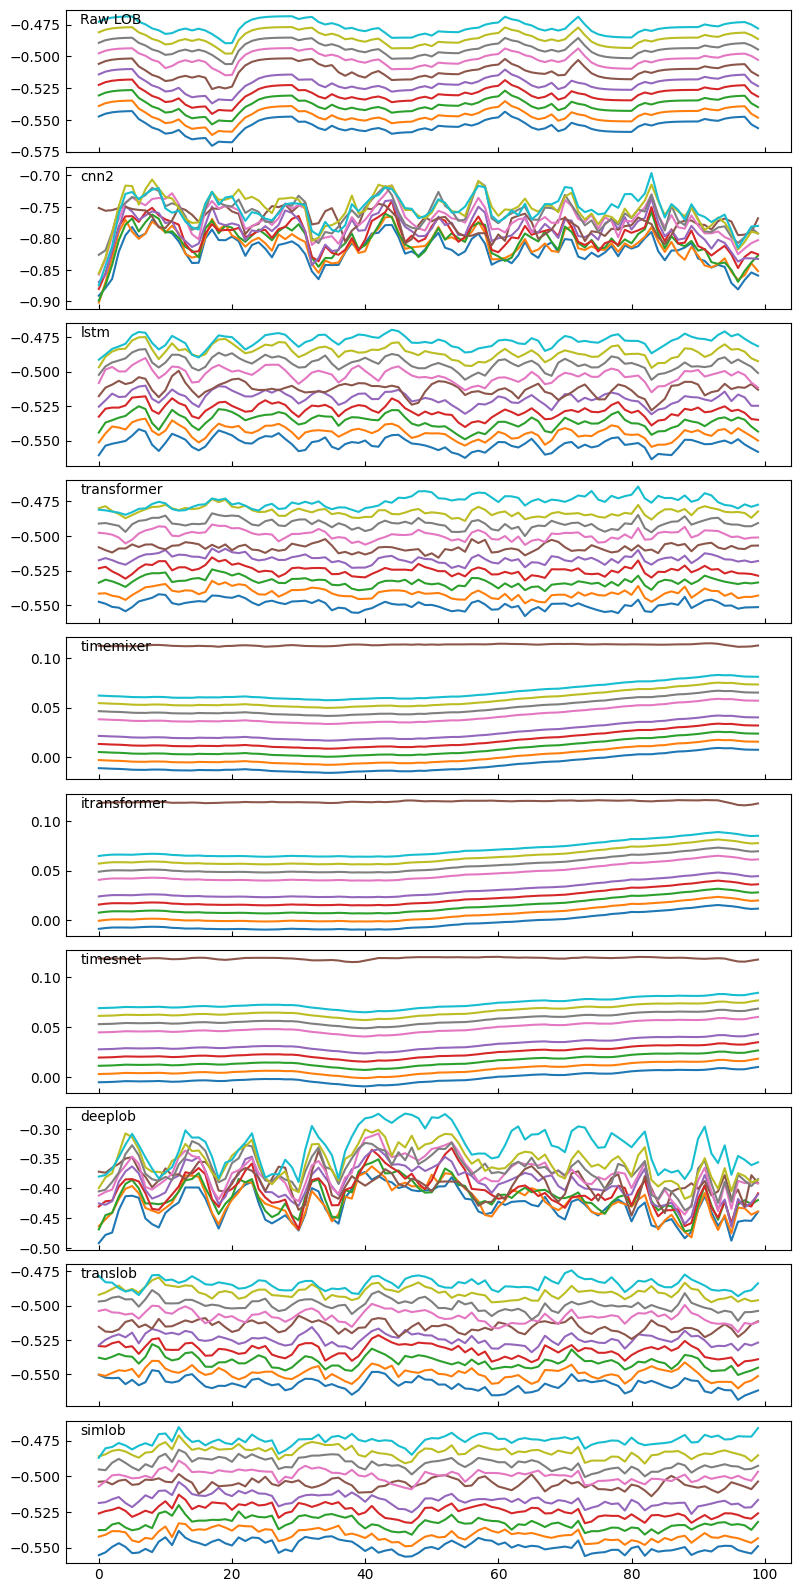

In [90]:
index = 8915


def ewma(data, alpha=0.3):
    result = np.zeros_like(data)
    result[0] = data[0]
    for t in range(1, len(data)):
        result[t] = alpha * data[t] + (1 - alpha) * result[t-1]
    return result

def plot_datas(dataset,index=8915, smooth=True, smooth_arg=5,save_pdf="./report/results/figures/reconstruction_comparison.pdf"):
    """
    在一个 figure 中创建两个子图，对比两组数据的“价”走势。
    不绘制“量”，只展示价格。
    """
    # 创建一个大画布，左右两个子图
    total = len(models_name)
    data_list = []
    data_list.append(dataset[index][0].numpy().T)
    input_data = dataset[index][0].unsqueeze(0)
    

    for name in models_name:
        if name in  ["itransformer","timesnet","timemixer"]:
            tmp = models[name].reconstruction(input_data).detach().numpy().T
        else:
            tmp = models[name](input_data,None).detach().numpy().T
        data_list.append(tmp)

    fig, axs = plt.subplots(total+1,1, figsize=(8,16))
    for i, ax in enumerate(axs):
        data = data_list[i]
        price_data = data[:20, :].copy()
        if smooth:
            for ii in range(20):
                price_data[ii] = ewma(price_data[ii], alpha=smooth_arg)

        # 设置坐标刻度向内
        ax.tick_params(axis='both', direction='in')
        # 绘制价格数据
        for j in range(20):
            if j%2==0:
                ax.plot(price_data[j], label=f"Price{j+1}")
        if i == 0:
            title = "Raw LOB"
        else:
            title = f"{models_name[i-1]}"

        # 在子图内部（左上角）添加标题文本
        ax.text(0.02, 0.98, title, transform=ax.transAxes,
                fontsize=10, verticalalignment='top')


        if i!=total:
            ax.set_xticklabels([])
        # ax.set_ylabel("Price")
        # ax.set_title(f"Price Data {i+1}")
        # ax.legend(loc='best')

        
    plt.tight_layout(pad=1.0)
    plt.subplots_adjust(hspace=0.1)
    plt.show()
    if save_pdf:
        fig.savefig(save_pdf)
    

plot_datas(d_dataset,index= 19000, smooth=True,smooth_arg=0.5,save_pdf="./doc/paper/figures/results/reconstruction_comparison3.pdf")

In [52]:
it = models['itransformer']

In [54]:
for p in it.parameters():
    print(p)

Parameter containing:
tensor([[-0.0534,  0.0240,  0.0491,  ..., -0.0287,  0.0513,  0.0016],
        [ 0.0252, -0.0143,  0.0302,  ..., -0.0597, -0.0496,  0.0429],
        [-0.0696, -0.0327, -0.0012,  ...,  0.0809,  0.0690,  0.0604],
        ...,
        [-0.0779, -0.0072, -0.0764,  ...,  0.0512, -0.0811, -0.0405],
        [-0.0422,  0.0215, -0.0937,  ...,  0.0558,  0.0776,  0.0883],
        [ 0.0184, -0.0880,  0.0752,  ..., -0.0813,  0.0492,  0.0241]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0056,  0.0309,  0.0484,  0.0345,  0.0386, -0.0198,  0.0962, -0.0193,
         0.0702,  0.0867, -0.0096, -0.0964, -0.0077,  0.0624,  0.0267, -0.0995,
         0.0593,  0.0698, -0.0496, -0.0938, -0.0213, -0.0975,  0.1034,  0.0857,
         0.0485,  0.0252, -0.0072, -0.0377,  0.0595, -0.0680, -0.0705, -0.0404,
         0.0233,  0.0509,  0.0864, -0.0226,  0.0697,  0.0281, -0.0829,  0.0268,
         0.0803,  0.0724,  0.0830, -0.0519, -0.0020,  0.0271, -0.0383, -0.0402,
         0.0561

In [61]:
import torch

In [76]:
data1 = d_dataset[0][0].unsqueeze(0)
data2 = d_dataset[1][0].unsqueeze(0)
it = models['timemixer']
t1 = it.encode(data1)
t2 = it.encode(data2)

t1 = t1.unsqueeze(1)
t2 = t2.unsqueeze(1)

memory = torch.zeros(t1.shape[0],t1.shape[1],t1.shape[2],device=t1.device)

t1 = it.decoder(t1,memory)
t2 = it.decoder(t2,memory)



# t1 = it.decode_proj(t1)
# t2 = it.decode_proj(t2)

t1 = t1.view(t1.shape[0],-1)
t2 = t2.view(t2.shape[0],-1)



t1 = it.decode_proj.linear_min1(t1)
t1 = torch.functional.F.relu(t1)


print(t1>0)


# t1==t2

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [ ]:
par = it.decode_proj.
for p in par:
    print(p)

Parameter containing:
tensor([[ 0.0222,  0.0089, -0.0423,  ...,  0.0440,  0.0433, -0.0099],
        [-0.0498,  0.0437,  0.0097,  ..., -0.0512, -0.0197, -0.0203],
        [ 0.0218,  0.0549,  0.0733,  ..., -0.0685,  0.0140,  0.0276],
        ...,
        [-0.0467,  0.0761,  0.0230,  ..., -0.0592, -0.0330,  0.0387],
        [ 0.0352, -0.0182,  0.0152,  ..., -0.0337, -0.0553, -0.0359],
        [ 0.0152, -0.0294,  0.0113,  ..., -0.0285,  0.0771,  0.0206]],
       requires_grad=True)
Parameter containing:
tensor([ 3.7283e-02,  7.9706e-03, -2.0343e-02, -1.2372e-02, -1.6628e-02,
        -5.9079e-02,  3.2983e-02,  1.0943e-02,  4.1500e-02,  4.1908e-02,
         4.8917e-02, -7.8500e-02, -7.1157e-02, -3.1993e-02,  2.4854e-02,
         1.5409e-02, -5.6956e-02,  1.6474e-02, -6.9132e-02, -5.8019e-02,
        -2.6710e-02,  2.4325e-02, -1.9628e-02,  3.8925e-02,  3.0212e-02,
        -8.1128e-02,  6.3512e-03,  1.3711e-02, -7.5528e-02, -6.9990e-03,
        -2.7469e-02,  5.3899e-03, -3.2005e-02, -2.7675e-0

In [74]:
tr = models['transformer']
prtr = tr.decode_proj.parameters()
for p in prtr:
    print(p)

Parameter containing:
tensor([[-0.1091,  0.0585,  0.0014,  ..., -0.0263, -0.0007,  0.1327],
        [-0.1366, -0.0265, -0.0361,  ..., -0.0460,  0.0269, -0.0193],
        [ 0.0756, -0.0284,  0.0053,  ..., -0.0399, -0.1385,  0.0531],
        ...,
        [-0.0060, -0.0253,  0.0184,  ...,  0.0028,  0.0575,  0.0510],
        [-0.0336,  0.0274, -0.0253,  ...,  0.0422,  0.0206, -0.0275],
        [-0.0189,  0.0278,  0.0312,  ...,  0.0852, -0.0146, -0.0472]],
       requires_grad=True)
Parameter containing:
tensor([ 2.3752e-02, -3.3421e-02,  3.3633e-02, -2.2965e-02,  1.0582e-02,
         1.1938e-02,  1.0690e-02, -2.3782e-02,  7.8096e-02,  7.6409e-02,
         7.4223e-02,  4.5497e-04, -2.1739e-02,  1.6898e-02,  8.7460e-02,
         6.0639e-02,  7.7055e-02,  4.4702e-02,  3.5598e-02, -4.7540e-03,
         7.6837e-02,  4.3265e-02,  5.9351e-02,  4.0001e-04,  3.2550e-03,
         6.4265e-02,  2.9012e-02,  9.4344e-04,  3.9437e-02, -1.3674e-02,
         1.8089e-02, -2.7506e-02,  6.2874e-02, -1.6886e-0